In [86]:
import pandas as pd
import yfinance as yf

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [87]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [88]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple feedforward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\genas\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26114.8574 - val_loss: 21117.3438 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23680.2109 - val_loss: 17598.1816 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13854.2373 - val_loss: 6607.3892 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4936.1675 - val_loss: 5218.8647 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3272.1987 - val_loss: 2774.4478 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2250.7795 - val_loss: 1320.7911 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1409.8683 - val_loss: 649.3151 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 926.0956 - val_loss: 323.9987 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 695.1064 - val_loss

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² Score: 0.9557


In [93]:
import os
from datetime import datetime

# Convert predictions to Series if needed
if not isinstance(y_pred, pd.Series):
    y_pred = pd.Series(y_pred.flatten(), index=y_test.index)

# Create a DataFrame with true, predicted, and timestamp
save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
result_df = pd.DataFrame({
    'Ticker': [tckr] * len(y_test),
    'Actual': y_test.values,
    'Predicted': y_pred.values,
    'Saved': [save_time] * len(y_test),
    'R2 Score': [r2] * len(y_test),
}, index=y_test.index)

# Define path
csv_path = 'predictions_log.csv'

# Check if file exists
if os.path.exists(csv_path):
    # Append to the existing file
    result_df.to_csv(csv_path, mode='a', header=False)
else:
    # Create a new file with headers
    result_df.to_csv(csv_path, mode='w', header=True)

print(f"✅ Results saved to {csv_path} at {save_time}")

✅ Results saved to predictions_log.csv at 2025-06-02 22:17:05


In [94]:
y_test

Date
2024-04-30    155.026345
2024-05-01    152.158503
2024-05-02    153.760252
2024-05-03    151.928271
2024-05-06    155.726512
                 ...    
2025-05-27     97.089996
2025-05-28     97.769997
2025-05-29     94.760002
2025-05-30     93.459999
2025-06-02     93.320000
Name: Next_High, Length: 273, dtype: float64

In [95]:
y_pred

Date
2024-04-30    155.810562
2024-05-01    152.362762
2024-05-02    152.025375
2024-05-03    153.083435
2024-05-06    152.482513
                 ...    
2025-05-27     98.420769
2025-05-28     99.254799
2025-05-29     97.677086
2025-05-30     96.071907
2025-06-02     95.975723
Length: 273, dtype: float32

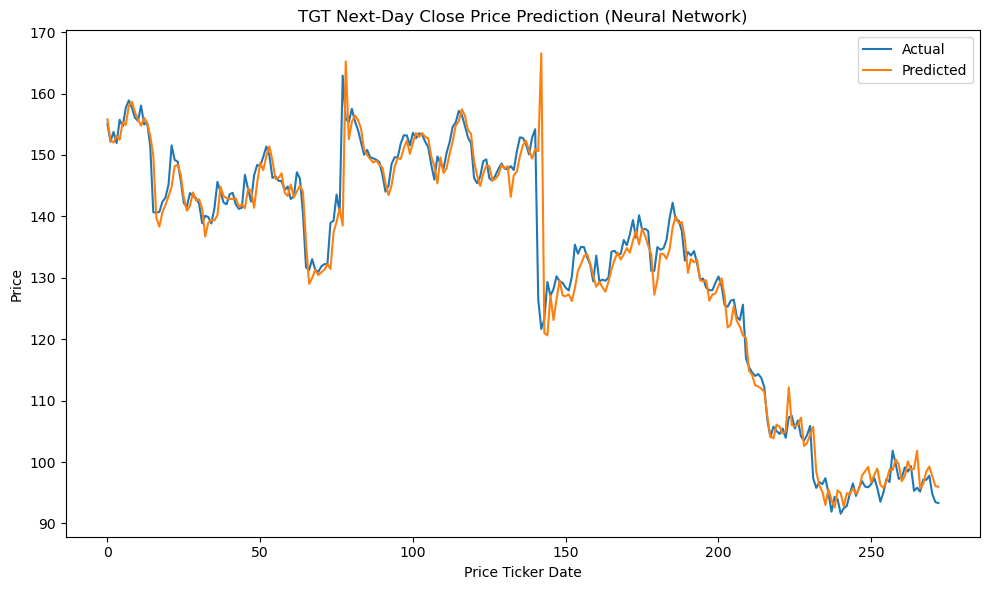

In [96]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Price Ticker Date') #('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

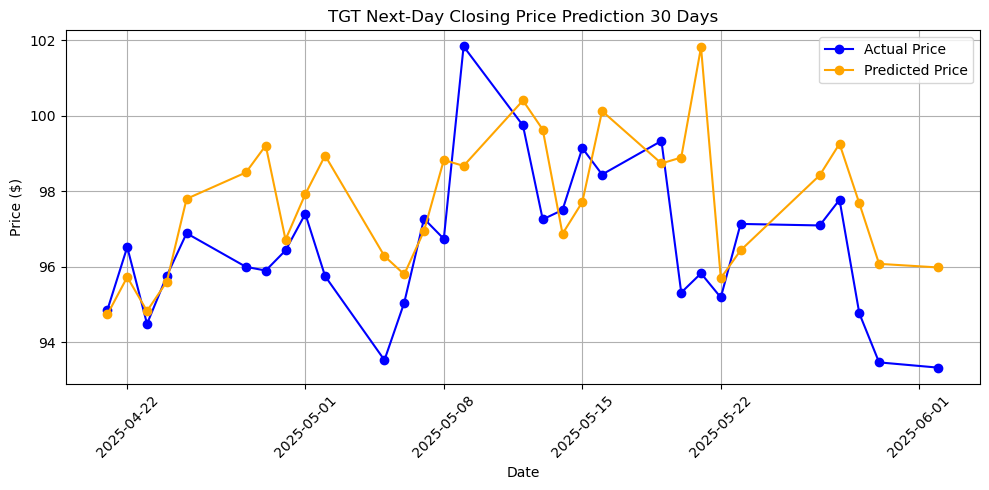

In [97]:
# Extract last 5 days of test predictions and actuals
last_n = 30
y_test_last = y_test[-last_n:]
y_pred_last = y_pred[-last_n:]

# Extract corresponding dates
if isinstance(y_test.index, pd.DatetimeIndex):
    test_dates = y_test.index[-last_n:]
else:
    # fallback if index is not datetime (e.g., RangeIndex)
    test_dates = pd.date_range(end=pd.Timestamp.today(), periods=last_n)

# Plot last week only
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_last.values, label='Actual Price', marker='o', color='blue')
plt.plot(test_dates, y_pred_last, label='Predicted Price', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{tckr} Next-Day Closing Price Prediction {last_n} Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [98]:
df

Price,Open,High,Low,Close,Volume,Next_High
Ticker,TGT,TGT,TGT,TGT,TGT,
Date,,,,,,
2020-01-02,112.422797,112.562507,109.383868,110.091202,5149800,109.619646
2020-01-03,108.859919,109.619646,108.222440,108.947243,5018500,108.851176
2020-01-06,108.257363,108.851176,107.602422,107.916794,4226900,108.659058
2020-01-07,107.410303,108.659058,107.410303,108.108910,3641600,109.375133
2020-01-08,108.327230,109.375133,107.707213,107.759613,5731600,109.078231
...,...,...,...,...,...,...
2025-05-27,95.559998,97.129997,94.879997,96.989998,6501800,97.089996
2025-05-28,96.989998,97.089996,95.769997,95.940002,4476000,97.769997
